<a href="https://colab.research.google.com/github/mauriciodev/spatialgeodesy/blob/main/exercises/Ex_4_Ionospheric_delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4 - Ionospheric delay

In this exercise we are going to download one Global Ionosphere Map from IGS (International GNSS Service) and plot the daily Vertical Total Electron Content on a given coordinate. 
We will also plot the Ionospheric delay computed with the Klobuchar model.

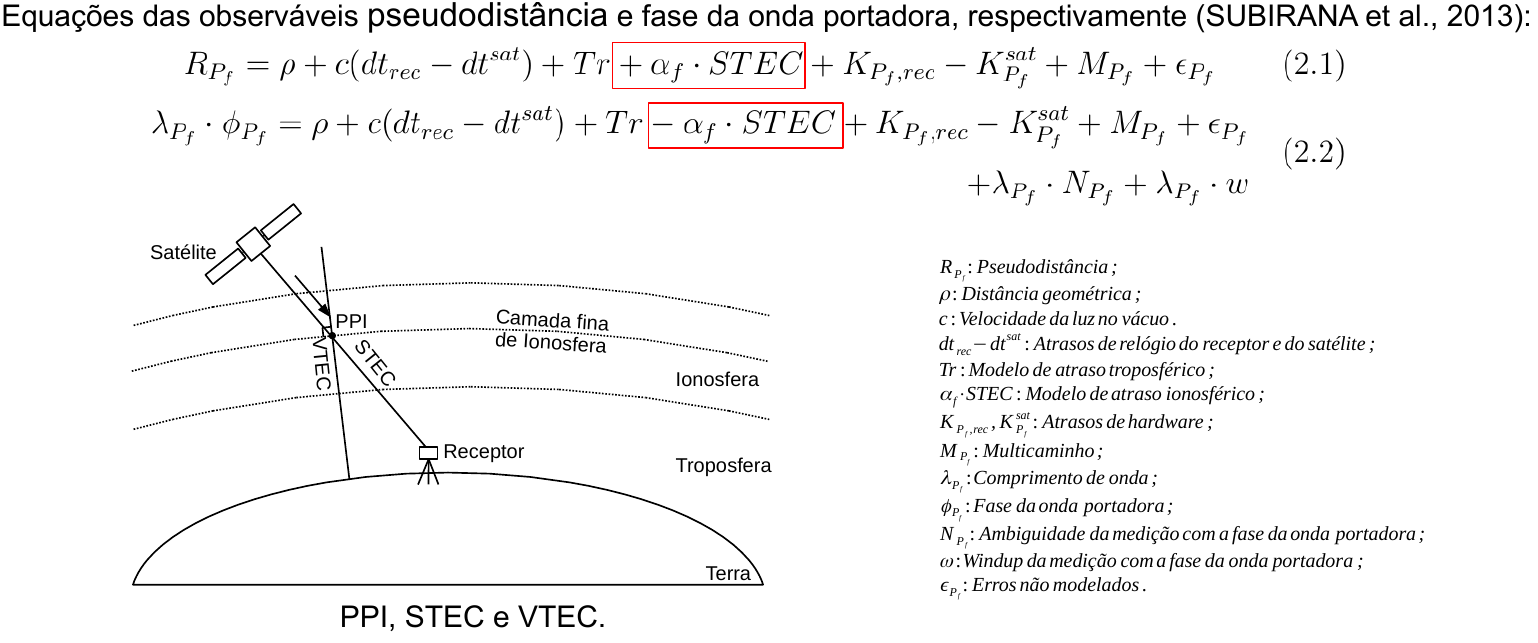

# Preparation

In [1]:
#Python standard libraries
import os #File path operations.
import shutil #Shell operations. Unzipping, moving files, etc.
import urllib.request #Downloader.
from urllib.parse import urlparse #url manipulation
import re #regular expressions to manipulate strings.
from datetime import datetime, timedelta

#External libraries
import numpy as np #Numeric Python.
import pandas as pd #Python Data Analysis Library.
import matplotlib.pyplot as plt #Plots.
import xarray as xa #Multi dimension arrays. For georinex.   

## Installing dependencies

In [2]:
# Installing the package that reads rinex and sp3 files
!pip install --upgrade pip
#!pip install git+https://github.com/geospace-code/georinex
!pip install git+https://github.com/breid-phys/georinex.git
# We are using a different georinex version 
# The speed for loading RINEX 3 files on current georinex is terrible.
import georinex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/breid-phys/georinex.git to /tmp/pip-req-build-p9adh9n4
  Running command git clone --filter=blob:none --quiet https://github.com/breid-phys/georinex.git /tmp/pip-req-build-p9adh9n4
  Resolved https://github.com/breid-phys/georinex.git to commit b76b692b8c497593e1c2b07fd26dc4f244dbe366
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.3/892.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.9

# Input parameters

In [3]:
#This is the reference time. We are going to use it to download the files.
t = pd.to_datetime('2023-01-01 02:00:01') 
station="RJNI" #This is the station. 

# Downloading nav data

In [4]:
year = t.year
dayOfYear = t.day_of_year
twoDigitYear = t.year %100

url_v3=f"https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados_RINEX3/{year}/orbitas/BRDC00WRD_R_{year}{dayOfYear:03}0000_01D_MN.rnx.gz"
print("URL for the RINEX 3 navigation file:\n", url_v3)

navRinexFile_v3=os.path.split(url_v3)[1] 
urllib.request.urlretrieve(url_v3, navRinexFile_v3) #download the file saving as the name in obsRinexFile_v3
print(navRinexFile_v3)


URL for the RINEX 3 navigation file:
 https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados_RINEX3/2023/orbitas/BRDC00WRD_R_20230010000_01D_MN.rnx.gz
BRDC00WRD_R_20230010000_01D_MN.rnx.gz


# Loading the navigation data
Note that on the bottom of the xarray dataset we have the ionospheric correction parameters from each system. These values were broadcast on the GNSS messages, sent by each satellite. Each system has a different ionospheric delay model.

In [5]:
navData=georinex.load(navRinexFile_v3, use='G')
navData

<xarray.Dataset>
Dimensions:           (time: 30, sv: 31)
Coordinates:
  * time              (time) datetime64[ns] 2022-12-31T23:59:44 ... 2023-01-02
  * sv                (sv) <U3 'G01' 'G02' 'G03' 'G04' ... 'G30' 'G31' 'G32'
Data variables: (12/31)
    SVclockBias       (time, sv) float64 nan nan nan ... -0.0002051 -0.0003501
    SVclockDrift      (time, sv) float64 nan nan nan ... -1.137e-12 -1.273e-11
    SVclockDriftRate  (time, sv) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    IODE              (time, sv) float64 nan nan nan nan ... 21.0 107.0 63.0
    Crs               (time, sv) float64 nan nan nan nan ... 0.2188 9.156 -8.312
    DeltaN            (time, sv) float64 nan nan nan ... 4.676e-09 4.682e-09
    ...                ...
    TGD               (time, sv) float64 nan nan nan ... -1.35e-08 4.657e-10
    IODC              (time, sv) float64 nan nan nan nan ... 21.0 107.0 63.0
    TransTime         (time, sv) float64 nan nan nan ... 7.922e+04 7.922e+04
    FitIntvl          (time, sv) float64 nan nan nan nan nan ... 4.0 4.0 4.0 4.0
    spare0            (time, sv) float64 nan nan nan nan nan ... nan nan nan nan
    spare1            (time, sv) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    ionospheric_corr_GPS:  [ 2.0489e-08  0.0000e+00 -5.9605e-08  1.1921e-07  ...
    ionospheric_corr_GAL:  [129.0, -0.59375, 0.00061035]
    ionospheric_corr_BDS:  [ 2.7008e-08  1.2666e-07 -1.2517e-06  1.9670e-06  ...
    ionospheric_corr_IRN:  [ 5.4948e-08  4.8429e-07 -1.8477e-06 -7.5102e-06  ...
    version:               3.04
    svtype:                ['G']
    rinextype:             nav
    filename:              BRDC00WRD_R_20230010000_01D_MN.rnx.gz

In [6]:
alpha=navData.ionospheric_corr_GPS[:4]
beta=navData.ionospheric_corr_GPS[4:]
print("Navigation ionospheric GPS Alpha", alpha)
print("Navigation ionospheric GPS Beta", beta)

Navigation ionospheric GPS Alpha [ 2.0489e-08  0.0000e+00 -5.9605e-08  1.1921e-07]
Navigation ionospheric GPS Beta [ 141310. -196610.       0.  196610.]


# Klobuchar model function
This function was translated from the Fortan code in https://geodesy.noaa.gov/gps-toolbox/ovstedal/klobuchar.for

Example: KLOBUCHAR(lat,lon,elev,azimuth,tow,alfa,beta)

Inputs :                                                     \\
* lat            : Geodetic latitude of receiver          (deg) 
* lon        : Geodetic longitude of receiver         (deg) 
* elev          : Elevation angle of satellite           (deg) 
* azimuth       : Geodetic azimuth of satellite          (deg) 
* tow           : Time of Week                           (sec)
* alfa[4]       : The coefficients of a cubic equation representing the amplitude of the vertical delay (4 coefficients - 8 bits each)
* beta[4]       : The coefficients of a cubic equation representing the period of the model (4 coefficients - 8 bits each) 

Output: 
* dIon1         : Ionospheric slant range correction for the L1 frequency                       (metre)

## Klobuchar implementation 

In [16]:
# Original code in Fortran: https://geodesy.noaa.gov/gps-toolbox/ovstedal/klobuchar.for
#      SUBROUTINE KLOBUCHAR(fi,lambda,elev,azimuth,tow,alfa,beta,dIon1)
#C     ==================================================================
#C     Subroutine for computing an Ionospheric range correction for the *
#C     GPS L1 frequency from the parameters broadcasted in the GPS      *
#C     Navigation Message.                                              *
#C     ==================================================================
#C     References:                                                      *
#C     Klobuchar, J.A., (1996) "Ionosphercic Effects on GPS", in        *
#C       Parkinson, Spilker (ed), "Global Positioning System Theory and *
#C       Applications, pp.513-514.                                      *
#C     ICD-GPS-200, Rev. C, (1997), pp. 125-128                         *
#C     NATO, (1991), "Technical Characteristics of the NAVSTAR GPS",    *
#C       pp. A-6-31   -   A-6-33                                        *
#C     ==================================================================
#C     Author : Ola Ovstedal, Department of Mapping Sciences            *
#C                            Agricultural University of Norway         *
#C     Date   : 06.03.2000                  Last modified : 20.11.2000  *
#C     ==================================================================
#C     Input :                                                          *
#C       fi            : Geodetic latitude of receiver          (deg)   *
#C       lambda        : Geodetic longitude of receiver         (deg)   *
#C       elev          : Elevation angle of satellite           (deg)   *
#C       azimuth       : Geodetic azimuth of satellite          (deg)   *
#C       tow           : Time of Week                           (sec)   *
#C       alfa(4)       : The coefficients of a cubic equation           *
#C                       representing the amplitude of the vertical     *
#C                       dalay (4 coefficients - 8 bits each)           *
#C       beta(4)       : The coefficients of a cubic equation           *
#C                       representing the period of the model           *
#C                       (4 coefficients - 8 bits each)                 *
#C     Output:                                                          *
#C       dIon1         : Ionospheric slant range correction for         *
#C                       the L1 frequency                       (metre) *
#C     ==================================================================
#C
#REAL*8 alfa(4),beta(4),fi,lambda,elev,e,azimuth,a,tow,t,
#+       dIon1,psi,lat_i,long_i,lat_m,sf,PER,AMP,x,deg2semi,
#+       semi2rad,deg2rad,pi,c
def KLOBUCHAR(lat,lon,elev,azimuth,tow,alfa,beta):

  c        =  2.99792458e8                  # speed of light
  deg2semi =  1.0/180.0                     # degrees to semicircles
  semi2rad =  np.pi                         # semicircles to radians
  deg2rad  =  np.pi/180.0                   # degrees to radians

  a = azimuth*deg2rad                       # azimuth in radians
  e = elev*deg2semi                         # elevation angle in
                                            # semicircles

  psi = 0.0137 / (e+0.11) - 0.022     # Earth Centered angle

  lat_i = lat*deg2semi + psi*np.cos(a)         # Subionospheric lat
  if (lat_i > 0.416):
    lat_i = 0.416
  elif (lat_i < -0.416):
    lat_i = -0.416
                                            # Subionospheric long
  long_i = lon*deg2semi + (psi*np.sin(a)/np.sin(lat_i*semi2rad))
                                            # Geomagnetic latitude
  lat_m = lat_i + 0.064*np.cos((long_i-1.617)*semi2rad)

  #Check the potency of 10 later
  t = 4.32e4*long_i + tow 
  t = t % 86400.                      # Seconds of day
  if (t > 86400.):  t = t - 86400.
  if (t < 0.):      t = t + 86400.

  sF = 1. + 16.*(0.53-e)**3           # Slant factor

                                            # Period of model
  PER = beta[0] + beta[1]*lat_m + beta[2]*lat_m**2 +beta[3]*lat_m**3

  if (PER < 72000.): PER = 72000.

  x = 2.*np.pi*(t-50400.)  /  PER          # Phase of the model
                                            # (Max at 14.00 =
                                            # 50400 sec local time)
                                            # Amplitud of the model
  AMP = alfa[0] + alfa[1]*lat_m + alfa[2]*lat_m**2 +alfa[3]*lat_m**3
  if(AMP < 0.): AMP = 0.

                                            # Ionospheric corr.
  if (abs(x) > 1.57):
    dIon1 = sF * (5e-9)
  else:
    dIon1 = sF * (5e-9 + AMP*(1. - x*x/2. + x*x*x*x/24.))

  dIon1 = c * dIon1
  return dIon1

## Time to seconds of week function
Example: secondsOfGPSWeek=gpsTimeOfWeek(t)

In [17]:
def gpsTimeOfWeek(t):
  gps_t0=pd.to_datetime('1980-01-06 00:00:00')
  deltaDate=t - gps_t0
  dayOfWeek= deltaDate.days % 7
  t_midnight=t.replace(hour=0, minute=0, second=0)
  secondsOfGPSWeek=(t-t_midnight).seconds+dayOfWeek*24*60*60
  return secondsOfGPSWeek

## Plots


In [9]:
#Klobuchar model inputs
lat=-30
lon=-50
elev=90
azimuth=0
# alfa and beta are from the nav file.
# time range for the delay series
t_range=pd.date_range(navData.time.min().values, navData.time.max().values, freq='30min')
ion_delay=[]
for t in t_range:
  tow=gpsTimeOfWeek(t)
  t_delay=KLOBUCHAR(lat,lon,elev,azimuth,tow,alpha,beta)
  ion_delay.append(t_delay)

Use the example bellow to understand how to plot a time series.

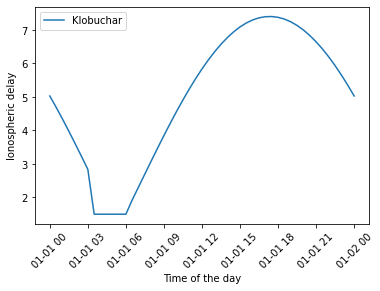

In [10]:
#plot t_range on X axis, ion_delay on Y axis
plt.plot(t_range,ion_delay, label="Klobuchar") 
plt.ylabel("Ionospheric delay")
plt.xlabel("Time of the day")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

# Ionosphere maps

## IONEX input parameters

Please note that IGN (French IGS distributor) doesn't have recent IONEX files, but they distribute data without any user authentication. So we will use 2020.

In [11]:
t = pd.to_datetime('2020-01-01 02:00:01') 


## Reader function

In [12]:
def read2DIonex(fileName):
        matrixList=[]
        data=None
        currMatrix=None
        currentEpoch=None
        m=n=z=0
        with open(fileName) as f:
            header=[]
            headerEnded=False
            daterange=None
            for line in f:
                if not headerEnded:
                    if not "END OF HEADER" in line:
                        header.append(line)
                        if "HGT1 / HGT2 / DHGT" in line:
                            #Ex:   450.0 450.0   0.0                                        HGT1 / HGT2 / DHGT  
                            values=re.split(' +', line.strip())
                            heighValues=[float(v) for v in values[0:3]] 
                            if heighValues[2]==0:
                                z=1
                            else:
                                z=int(float(heighValues[1]-heighValues[0])/heighValues[2])
                        elif "LAT1 / LAT2 / DLAT" in line:
                            #Ex:    87.5 -87.5  -2.5                                        LAT1 / LAT2 / DLAT  
                            values=re.split(' +', line.strip())
                            latValues=[float(v) for v in values[0:3]] 
                            n=int(float(latValues[1]-latValues[0])/latValues[2])+1
                        elif "LON1 / LON2 / DLON" in line:
                            #Ex:  -180.0 180.0   5.0                                        LON1 / LON2 / DLON
                            values=re.split(' +', line.strip())
                            lonValues=[float(v) for v in values[0:3]] 
                            m=int(float(lonValues[1]-lonValues[0])/lonValues[2])+1 #first colunm repeats
                        elif "EXPONENT" in line:
                            values=re.split(' +', line.strip())
                            scale=10**float(values[0])
                        elif "EPOCH OF FIRST MAP" in line:
                            values = re.split(' +', line)                
                            epoch=' '.join(values[1:7])
                            date_first=datetime.strptime(epoch, "%Y %m %d %H %M %S")
                        elif "EPOCH OF LAST MAP" in line:
                            values = re.split(' +', line)                
                            epoch=' '.join(values[1:7])
                            date_last=datetime.strptime(epoch, "%Y %m %d %H %M %S")
                        elif "INTERVAL" in line:
                            values = re.split(' +', line)  
                            interval=timedelta(seconds=int(values[1]))
                    else:
                        headerEnded=True
                        daterange=pd.date_range(date_first, date_last, freq=interval)
                else:
                    if "START OF TEC MAP" in line: #new epoch
                        currMatrix=np.zeros((n,m))
                    elif "END OF TEC MAP" in line: #SAVE THE OLDER MATRIX
                        matrixList.append(currMatrix)
                        currMatrix=None
                    elif "EPOCH OF CURRENT MAP" in line:
                        #  2021     4    25     8     0     0                        EPOCH OF CURRENT MAP
                        values = re.split(' +', line)                
                        epoch=' '.join(values[1:7])
                        currentEpoch=datetime.strptime(epoch, "%Y %m %d %H %M %S")
                    elif "LAT/LON1/LON2/DLON/H" in line:
                        lat=float(line[2:8])
                        lon1=float(line[8:14])
                        lon2=float(line[14:20])
                        dlon=float(line[20:26])
                        h=line[26:32]
                        row=int((lat-latValues[0])/latValues[2]) #find the row
                        #Not sure if I really need this info
                        col0=0#(lon1-self.lonValues[0])/self.lonValues[2]
                    else: #finally some data
                        if not currMatrix is None:
                            values=chunks(line.replace('\n',''),5)
                            values=[float(x) for x in values]
                            values=np.array(values)
                            nvals=len(values)
                            currMatrix[row,col0:col0+nvals]=values*scale
                            col0+=nvals
        outputArray=np.array(matrixList)
        transform=[lonValues[0],lonValues[2],0,latValues[0],0,latValues[2] ]
        return outputArray, transform, daterange

def chunks(l, n):  #split a line in chunks of size n
    return [l[i:i+n].strip() for i in range(0, len(l), n)]

## Downloading and reading the IONEX as a numpy 3D array.
Dimensions: time, lat, lon.


In [13]:
year = t.year
dayOfYear = t.day_of_year
ionex_url=f"ftp://igs.ign.fr/pub/igs/products/ionosphere/{year}/{dayOfYear:03}/codg{dayOfYear:03}0.{year%100}i.Z"
print("Downloading IONEX from", ionex_url)
ionexFile=ionex_url.split("/")[-1] #get the last part of url, which is the file.
urllib.request.urlretrieve(ionex_url,ionexFile) #download the file saving as the name in obsRinexFile_v3
print(ionexFile)
!uncompress $ionexFile -f #uncompressing .Z file.
uncomp_ionex= ionexFile[:-2]
print(uncomp_ionex)

codg0010.20i.Z
codg0010.20i


In [14]:
matrixList, transformation, daterange = read2DIonex(uncomp_ionex)
print("Dimensions of the IONEX file (time, lat, lon):",matrixList.shape)

Dimensions of the IONEX file (time, lat, lon): (25, 71, 73)


The IONEX files represent the VTEC maps of the entire globe.

# Plots
Now using the numpy array of the IONEX file plot the following:


## Plot the first VTEC Map
Example function to plot the 10th map: 

`plt.imshow(matrixList[10], extent=[-180,180,-90,90])` \
`plt.colorbar()`

In [15]:
#Plase fill this part of the code. Remember to add the xlabels, ylabels, legend, 
plt.imshow(            , extent=[-180,180,-90,90])
plt.colorbar()
plt.show()

SyntaxError: ignored

# Choose at least 3 pixels and plot the VTEC values of a single day.
Example: `plt.plot(matrixList[:,30,35], label='pixel 30,35')`

In [ ]:
#Please fill this part of the code.
